In [1]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split


In [2]:
encuesta=pd.read_csv("encuestalimpia.csv")

In [3]:
def drop_file(data,pregunta,valor):
    data = data[data[pregunta] != valor]
    return data

In [4]:
#elimino los valores ns y nc
encuesta = drop_file(encuesta,"P19",98)
encuesta = drop_file(encuesta,"P19",99)

In [5]:
etiquetas=[0,1,2]
cortes = [0,3,6,10]
encuesta["ideologia"] = pd.cut(encuesta['P19'],cortes, labels=etiquetas)
encuesta["ideologia"] = pd.to_numeric(encuesta["ideologia"])

In [6]:
encuesta=encuesta.drop(columns="P19")

In [7]:
variables_categoricas=["CAPITAL","CCAA","P0A","P14R","P22","P25","P26","P27","P28"]

In [8]:
encuesta2=encuesta.drop(columns=variables_categoricas)

In [9]:
encuesta2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9395 entries, 0 to 9730
Data columns (total 20 columns):
P2002        9395 non-null int64
P3           9395 non-null int64
P2           9395 non-null int64
P1304        9395 non-null int64
P2004        9395 non-null int64
P803         9395 non-null int64
P1303        9395 non-null int64
P1301        9395 non-null int64
P23          9395 non-null int64
P802         9395 non-null int64
P2001        9395 non-null int64
P801         9395 non-null int64
P1           9395 non-null int64
P4           9395 non-null int64
P804         9395 non-null int64
TAMUNI       9395 non-null int64
P1302        9395 non-null int64
ESTUDIOS     9395 non-null int64
P2003        9395 non-null int64
ideologia    9395 non-null int64
dtypes: int64(20)
memory usage: 1.5 MB


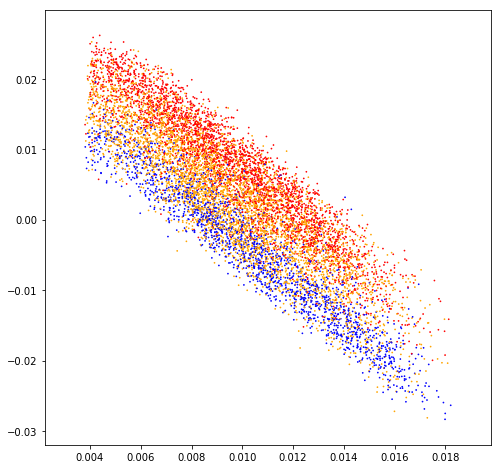

In [10]:
pca = PCA(n_components=2)
distribution_all=pca.fit(encuesta2.T) 
plt.figure(figsize=(8,8))
color= ['red' if ideologia == 0 
        else 'orange' if ideologia == 1
        else 'blue' if ideologia == 2
        else 'red' for ideologia in list(encuesta['ideologia'])]
plt.scatter(distribution_all.components_[0], distribution_all.components_[1],color=color,s=0.5)

In [11]:
col_names= encuesta2.columns
encuesta2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9395 entries, 0 to 9730
Data columns (total 20 columns):
P2002        9395 non-null int64
P3           9395 non-null int64
P2           9395 non-null int64
P1304        9395 non-null int64
P2004        9395 non-null int64
P803         9395 non-null int64
P1303        9395 non-null int64
P1301        9395 non-null int64
P23          9395 non-null int64
P802         9395 non-null int64
P2001        9395 non-null int64
P801         9395 non-null int64
P1           9395 non-null int64
P4           9395 non-null int64
P804         9395 non-null int64
TAMUNI       9395 non-null int64
P1302        9395 non-null int64
ESTUDIOS     9395 non-null int64
P2003        9395 non-null int64
ideologia    9395 non-null int64
dtypes: int64(20)
memory usage: 1.5 MB


In [12]:
k2, p_norm = stats.normaltest(encuesta2)
not_normal=[i for i in p_norm if i<0.05]

levene = []
for col in col_names:      

    l,p = (stats.levene(encuesta2[col][encuesta2['ideologia']==0], 
            encuesta2[col][encuesta2['ideologia']==1],
            encuesta2[col][encuesta2['ideologia']==2], 
            encuesta2[col][encuesta2['ideologia']==3],
            )) 
    levene.append((col, p))

not_homocedasticity=[i for i in p_norm if i<0.05]
print(len(not_homocedasticity),len(not_normal))

19 19


/home/vicente/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vicente/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
anova = []
for col in col_names:      

    a = (stats.f_oneway(encuesta2[col][encuesta2['ideologia']==0], 
            encuesta2[col][encuesta2['ideologia']==1],
            encuesta2[col][encuesta2['ideologia']==2], 
            )) 
    anova.append((col, a))
    
significant_columns=[i[0] for i in anova if i[1][1]<0.05]
len(significant_columns)


20

In [14]:
from sklearn.utils import shuffle
df_for_model=encuesta2[significant_columns]
df_for_model = shuffle(df_for_model) 


array([[ 0.01143421,  0.00886092,  0.00683005, ...,  0.01045524,
         0.00825091,  0.008793  ],
       [ 0.00721426,  0.01156841,  0.01365384, ..., -0.00442245,
         0.00867839,  0.01007048]])

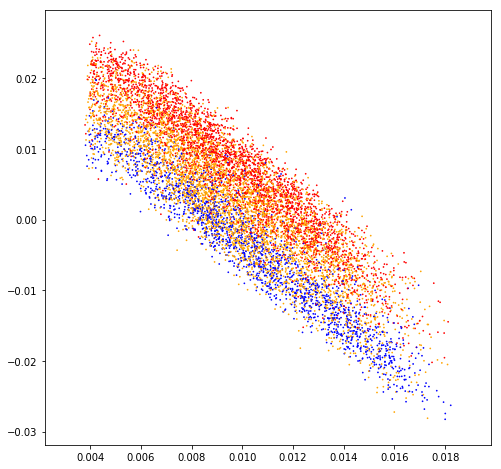

In [15]:
p=pca.fit(df_for_model.loc[:,df_for_model.columns!='ideologia'].T) 
color= ['red' if ideologia == 0 
        else 'orange' if ideologia == 1
        else 'blue' if ideologia == 2
        else 'red' for ideologia in list(df_for_model['ideologia'])]
plt.figure(figsize=(8,8))
plt.scatter(p.components_[0], p.components_[1],color=color,s=0.5)
p.components_


In [16]:
X=df_for_model.loc[:,df_for_model.columns!='ideologia']
y=df_for_model['ideologia']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

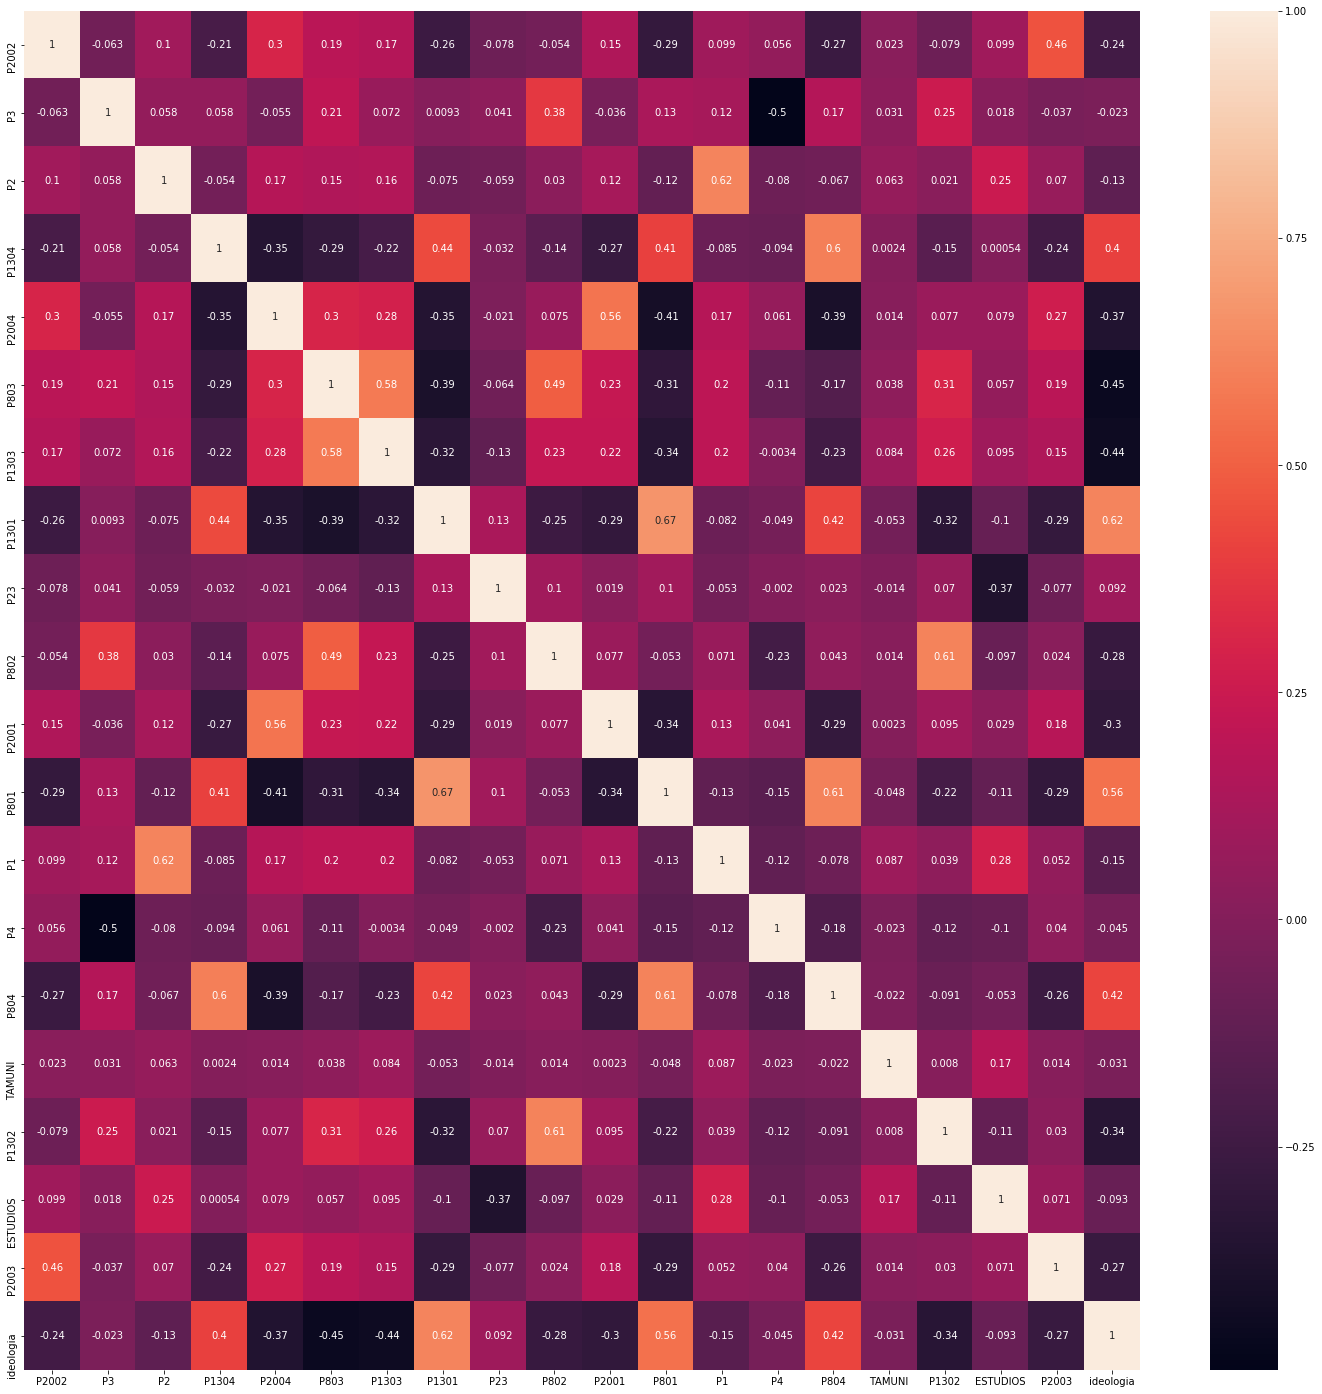

In [17]:
correlacion = encuesta2.corr()
fig, ax = plt.subplots(figsize = (25,25))
ax = sns.heatmap(correlacion, annot=True)
ax

In [18]:
def variablescolinealidad(data):
    columns_to_drop=[]                  
    for c in data.columns:
        for i in range(len(data.corr())):
            if abs(data.corr()[c][i])>0.9 and abs(data.corr()[c][i])<1:columns_to_drop.append(c)
    columns_to_drop=list(set(columns_to_drop))   
    return len(columns_to_drop)

In [19]:
variablescolinealidad(encuesta2)

0

In [20]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier           
from sklearn.neighbors import KNeighborsClassifier            
from sklearn.ensemble import GradientBoostingClassifier       
from sklearn.neural_network import MLPClassifier
#from sklearn.model_selection import GridSearchCV 
from sklearn import tree


In [21]:

lr = LogisticRegression(solver ='liblinear',max_iter=500)
#cls = svm.SVC(gamma='auto', probability=True)
neigh3 = KNeighborsClassifier(n_neighbors=3)
neigh5 = KNeighborsClassifier(n_neighbors=5)
bosque=RandomForestClassifier(n_estimators=100, criterion='gini')
#tree = tree.DecisionTreeClassifier()

#entrenando
#cls.fit(X_train, y_train)
lr.fit(X_train, y_train)
neigh3.fit(X_train, y_train) 
neigh5.fit(X_train, y_train) 
bosque.fit(X_train, y_train) 
#tree.fit(X_train, y_train)

/home/vicente/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
#y_predcls = cls.predict(X_test)
y_predlr = lr.predict(X_test)
y_pred_neigh3= neigh3.predict(X_test)
y_pred_neigh5= neigh5.predict(X_test)
y_pred_bosque= bosque.predict(X_test)
#y_pred_tree= tree.predict(X_test)
print("Accuracy lineal:",metrics.accuracy_score(y_test, y_predlr))
#print("Accuracy logistics:",metrics.accuracy_score(y_test, y_predlr))
print("Accuracy neigh3:",metrics.accuracy_score(y_test, y_pred_neigh3))
print("Accuracy neigh5:",metrics.accuracy_score(y_test, y_pred_neigh5))
print("Accuracy bosque:",metrics.accuracy_score(y_test, y_pred_bosque))
#print("Accuracy tree:",metrics.accuracy_score(y_test, y_pred_tree))


Accuracy lineal: 0.689196381053752
Accuracy neigh3: 0.6540713145290048
Accuracy neigh5: 0.6711016498137307
Accuracy bosque: 0.7450771687067589


In [23]:
import numpy as np

import statsmodels.api as sm

import statsmodels.formula.api as smf

In [24]:
results = smf.ols('ideologia ~ P2002 + P3 + P2 + P1304 + P2004 + P803 + P1303 + P1301 + P23 + P802 + P2001 + P801 + P1 + P4 + P804  + TAMUNI + P1302 + ESTUDIOS + P2003', data=df_for_model).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              ideologia   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     519.9
Date:                Sat, 01 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:07:40   Log-Likelihood:                -6703.4
No. Observations:                9395   AIC:                         1.345e+04
Df Residuals:                    9375   BIC:                         1.359e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2471      0.067     18.583      0.0

In [25]:
import statsmodels.api as sm
data = sm.datasets.stackloss.load()
data.exog = sm.add_constant(data.exog)
rlm_model = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
print(rlm_results.params)

[-41.02649835   0.82938433   0.92606597  -0.12784672]


/home/vicente/.local/lib/python3.5/site-packages/statsmodels/datasets/utils.py:100: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exog = np.column_stack(data[field] for field in exog_name)


In [26]:
results = smf.ols('ideologia ~ P2002 + P2 + P1304 + P2004 + P803 + P1303 + P1301 + P802 + P2001 + P801 + P4 + P804  + TAMUNI + P1302 + ESTUDIOS + P2003', data=df_for_model).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              ideologia   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     617.0
Date:                Sat, 01 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:07:41   Log-Likelihood:                -6705.7
No. Observations:                9395   AIC:                         1.345e+04
Df Residuals:                    9378   BIC:                         1.357e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2951      0.062     20.929      0.0

In [27]:
encuesta_dumf=pd.get_dummies(encuesta,columns=["CAPITAL","CCAA","P0A","P14R","P22","P25","P26","P27","P28"],drop_first=False)
encuesta_dum=pd.get_dummies(encuesta,columns=["CAPITAL","CCAA","P0A","P14R","P22","P25","P26","P27","P28"],drop_first=True)

In [28]:
print(len(encuesta_dum.columns))

70


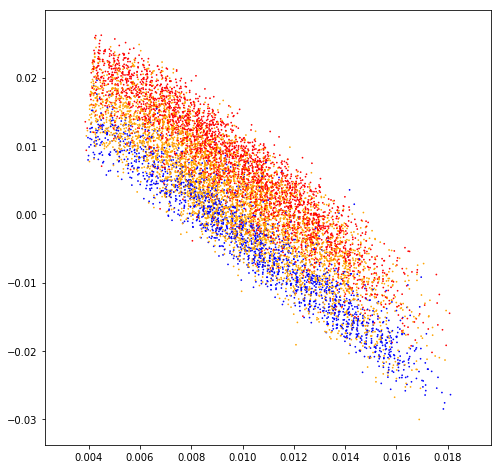

In [29]:
pca = PCA(n_components=2)
distribution_all=pca.fit(encuesta_dum.T) 
plt.figure(figsize=(8,8))
color= ['red' if ideologia == 0 
        else 'orange' if ideologia == 1
        else 'blue' if ideologia == 2
        else 'red' for ideologia in list(encuesta['ideologia'])]
plt.scatter(distribution_all.components_[0], distribution_all.components_[1],color=color,s=0.5)

In [30]:
k2, p_norm = stats.normaltest(encuesta_dum)
not_normal=[i for i in p_norm if i<0.05]

levene = []
for col in col_names:      

    l,p = (stats.levene(encuesta2[col][encuesta2['ideologia']==0], 
            encuesta2[col][encuesta2['ideologia']==1],
            encuesta2[col][encuesta2['ideologia']==2], 
            encuesta2[col][encuesta2['ideologia']==3],
            )) 
    levene.append((col, p))

not_homocedasticity=[i for i in p_norm if i<0.05]
print(len(not_homocedasticity),len(not_normal))

69 69


/home/vicente/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vicente/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


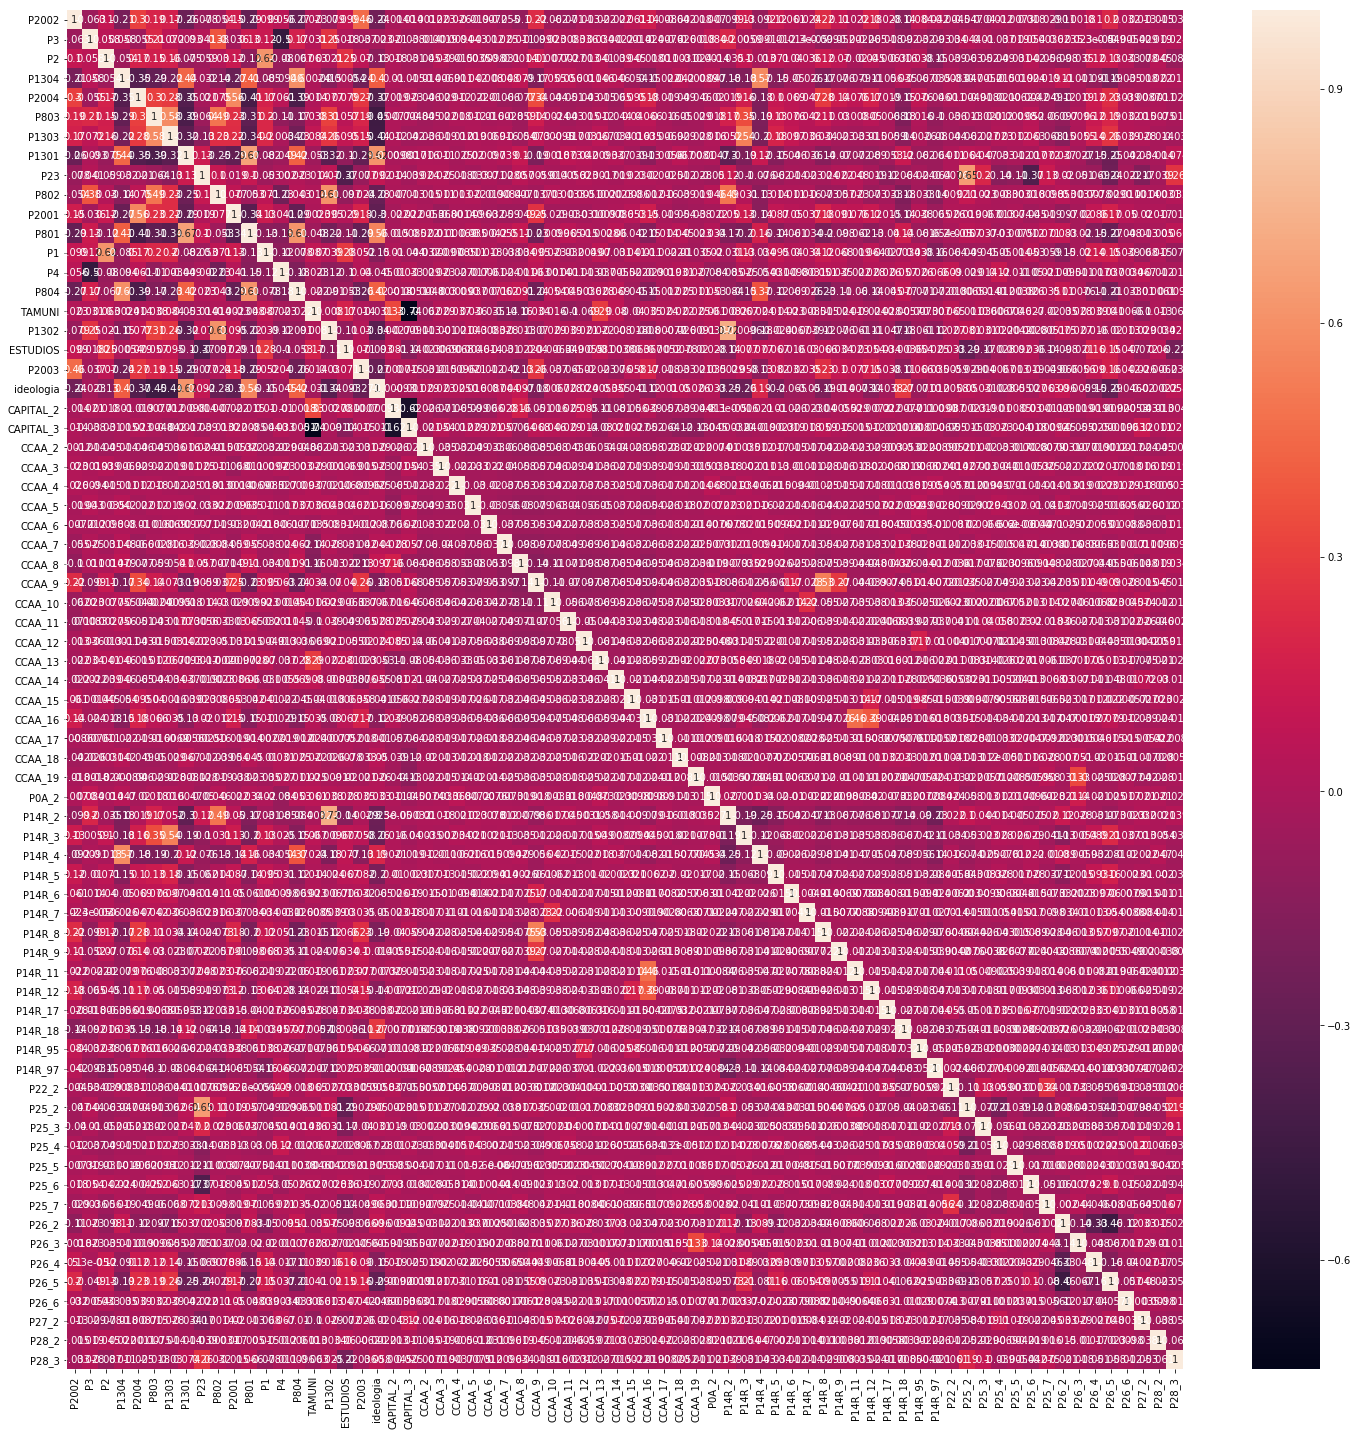

In [31]:
correlacion = encuesta_dum.corr()
fig, ax = plt.subplots(figsize = (25,25))
ax = sns.heatmap(correlacion, annot=True)
ax

In [32]:
variablescolinealidad(encuesta_dum)

0

In [37]:
X=encuesta_dumf.loc[:,encuesta_dumf.columns!='ideologia']
y=encuesta_dumf['ideologia']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [41]:
lr = LogisticRegression(solver ='liblinear',max_iter=500)
#cls = svm.SVC(gamma='auto', probability=True)
neigh3 = KNeighborsClassifier(n_neighbors=3)
neigh5 = KNeighborsClassifier(n_neighbors=5)
bosque=RandomForestClassifier(n_estimators=100, criterion='gini')
#tree = tree.DecisionTreeClassifier()

#entrenando
#cls.fit(X_train, y_train)
lr.fit(X_train, y_train)
neigh3.fit(X_train, y_train) 
neigh5.fit(X_train, y_train) 
bosque.fit(X_train, y_train) 
#tree.fit(X_train, y_train)

/home/vicente/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
#y_predcls = cls.predict(X_test)
y_predlr = lr.predict(X_test)
y_pred_neigh3= neigh3.predict(X_test)
y_pred_neigh5= neigh5.predict(X_test)
y_pred_bosque= bosque.predict(X_test)
#y_pred_tree= tree.predict(X_test)
print("Accuracy lineal:",metrics.accuracy_score(y_test, y_predlr))
#print("Accuracy logistics:",metrics.accuracy_score(y_test, y_predlr))
print("Accuracy neigh3:",metrics.accuracy_score(y_test, y_pred_neigh3))
print("Accuracy neigh5:",metrics.accuracy_score(y_test, y_pred_neigh5))
print("Accuracy bosque:",metrics.accuracy_score(y_test, y_pred_bosque))
#print("Accuracy tree:",metrics.accuracy_score(y_test, y_pred_tree))

Accuracy lineal: 0.7253858435337945
Accuracy neigh3: 0.6556679084619479
Accuracy neigh5: 0.6758914316125598
Accuracy bosque: 0.7413517828632251


In [45]:
results = smf.ols('ideologia ~ P2002+ P3 + P2 + P1304 + P2004 + P803 + P1303 + P1301 + P23 + P802 + P2001 + P801 + P1 + P4 + P804 + TAMUNI + P1302 + ESTUDIOS + P2003  + CAPITAL_1 + CAPITAL_2 + CAPITAL_3 + CCAA_1 + CCAA_2 +CCAA_3 + CCAA_4 + CCAA_5 + CCAA_6 + CCAA_7 + CCAA_8 + CCAA_9 + CCAA_10 + CCAA_11 + CCAA_12 + CCAA_13 + CCAA_14 + CCAA_15 + CCAA_16 + CCAA_17 + CCAA_18 + CCAA_19 + P0A_1 + P0A_2 + P14R_1 + P14R_2 + P14R_3 + P14R_4 + P14R_5 + P14R_6 + P14R_7 + P14R_8 + P14R_9 + P14R_11 +  P14R_12 + P14R_17 + P14R_18 + P14R_95 + P14R_97 + P22_1 + P22_2 + + P25_1 + P25_2 + P25_3 + P25_4 + P25_5 + P25_6 + P25_7 + + P26_1 + P26_2 + P26_3 + P26_4 + P26_5 + P26_6 + +P27_1 + P27_2 + P28_1 + P28_2 + P28_3', data=encuesta_dumf).fit()
 
# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              ideologia   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     190.6
Date:                Sat, 01 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:45:49   Log-Likelihood:                -5951.7
No. Observations:                9395   AIC:                         1.204e+04
Df Residuals:                    9325   BIC:                         1.254e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2648      0.021     12.760      0.0

In [46]:
results = smf.ols('ideologia ~ CAPITAL_1 + CAPITAL_2 + CAPITAL_3 + CCAA_1 + CCAA_2 +CCAA_3 + CCAA_4 + CCAA_5 + CCAA_6 + CCAA_7 + CCAA_8 + CCAA_9 + CCAA_10 + CCAA_11 + CCAA_12 + CCAA_13 + CCAA_14 + CCAA_15 + CCAA_16 + CCAA_17 + CCAA_18 + CCAA_19 + P0A_1 + P0A_2 + P14R_1 + P14R_2 + P14R_3 + P14R_4 + P14R_5 + P14R_6 + P14R_7 + P14R_8 + P14R_9 + P14R_11 +  P14R_12 + P14R_17 + P14R_18 + P14R_95 + P14R_97 + P22_1 + P22_2 + + P25_1 + P25_2 + P25_3 + P25_4 + P25_5 + P25_6 + P25_7 + + P26_1 + P26_2 + P26_3 + P26_4 + P26_5 + P26_6 + +P27_1 + P27_2 + P28_1 + P28_2 + P28_3', data=encuesta_dumf).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              ideologia   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     220.1
Date:                Sat, 01 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:46:03   Log-Likelihood:                -6428.5
No. Observations:                9395   AIC:                         1.296e+04
Df Residuals:                    9344   BIC:                         1.332e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.531e+11   2.25e+11     -1.123      0.2

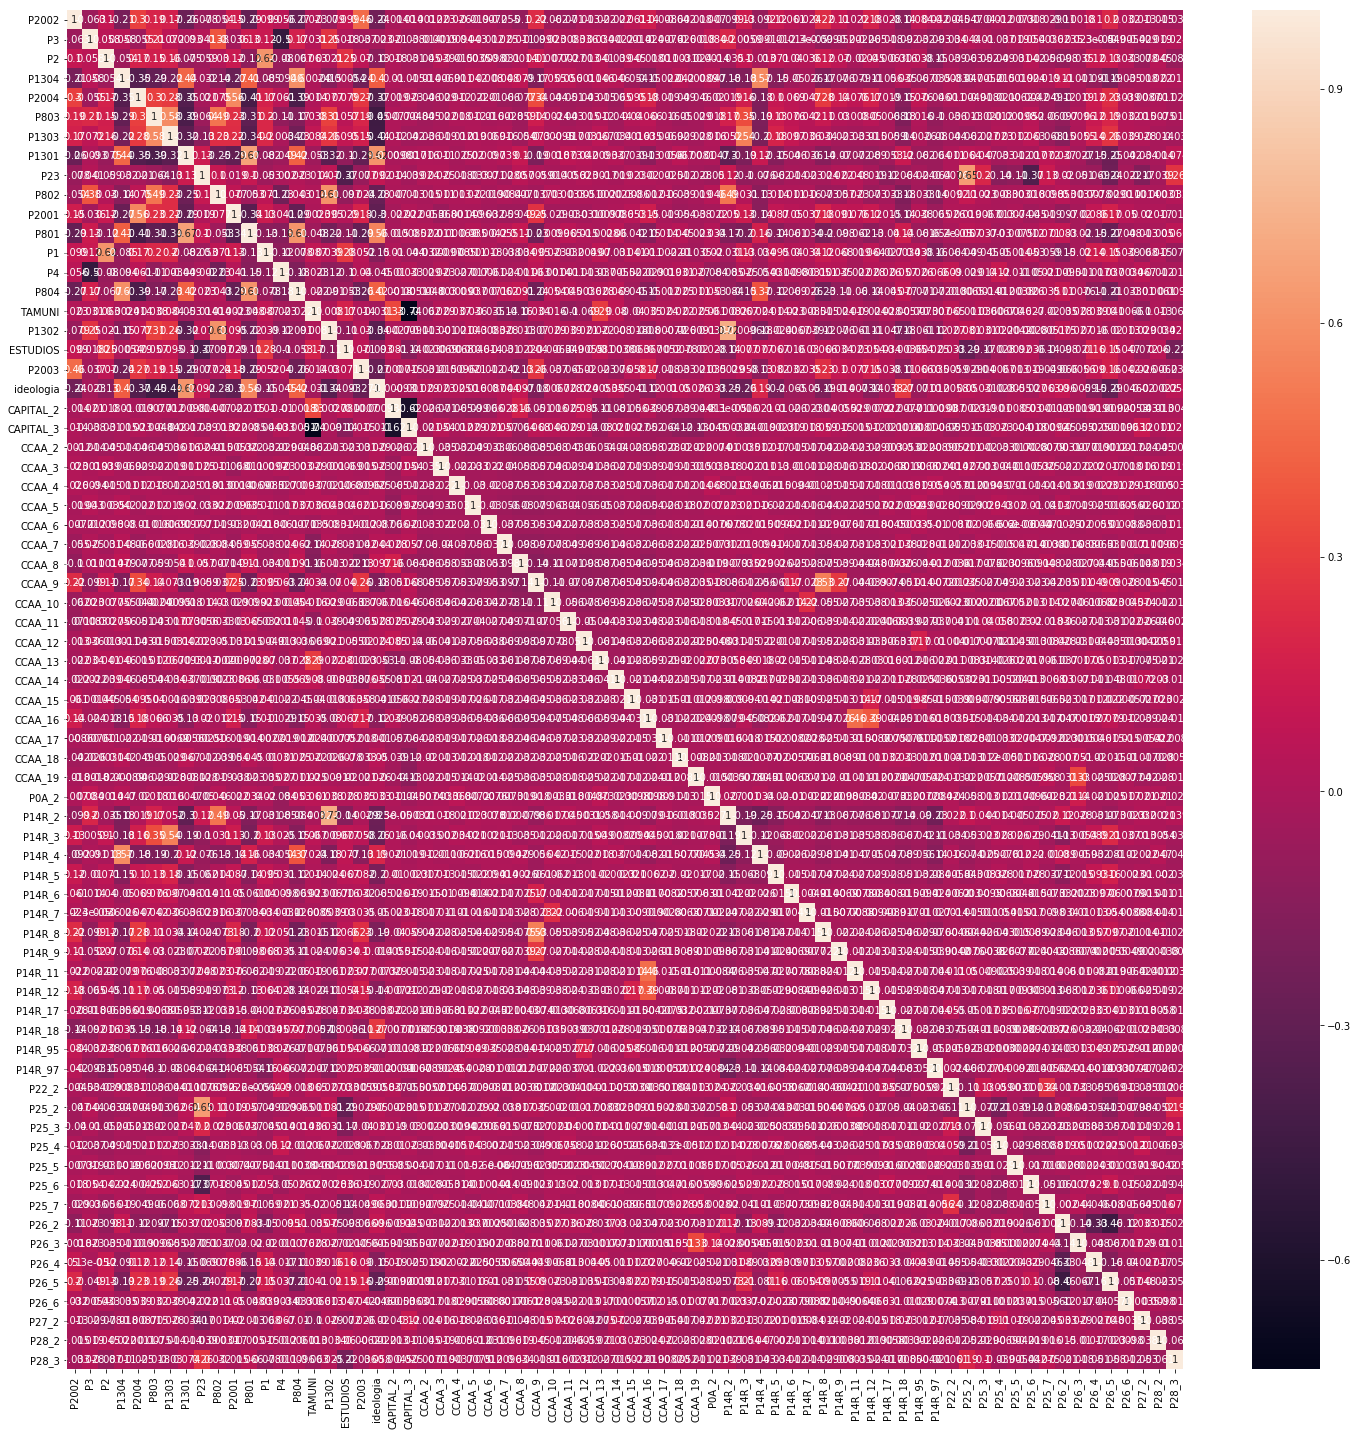

In [47]:
correlacion = encuesta_dum.corr()
fig, ax = plt.subplots(figsize = (25,25))
ax = sns.heatmap(correlacion, annot=True)
ax

In [48]:
variablescolinealidad(encuesta_dum)

0

In [49]:
X=encuesta_dum.loc[:,encuesta_dum.columns!='ideologia']
y=encuesta_dum['ideologia']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [52]:
lr = LogisticRegression(solver ='liblinear',max_iter=500)
#cls = svm.SVC(gamma='auto', probability=True)
neigh3 = KNeighborsClassifier(n_neighbors=3)
neigh5 = KNeighborsClassifier(n_neighbors=5)
bosque=RandomForestClassifier(n_estimators=100, criterion='gini')
#tree = tree.DecisionTreeClassifier()

#entrenando
#cls.fit(X_train, y_train)
lr.fit(X_train, y_train)
neigh3.fit(X_train, y_train) 
neigh5.fit(X_train, y_train) 
bosque.fit(X_train, y_train) 
#tree.fit(X_train, y_train)

/home/vicente/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
#y_predcls = cls.predict(X_test)
y_predlr = lr.predict(X_test)
y_pred_neigh3= neigh3.predict(X_test)
y_pred_neigh5= neigh5.predict(X_test)
y_pred_bosque= bosque.predict(X_test)
#y_pred_tree= tree.predict(X_test)
print("Accuracy lineal:",metrics.accuracy_score(y_test, y_predlr))
#print("Accuracy logistics:",metrics.accuracy_score(y_test, y_predlr))
print("Accuracy neigh3:",metrics.accuracy_score(y_test, y_pred_neigh3))
print("Accuracy neigh5:",metrics.accuracy_score(y_test, y_pred_neigh5))
print("Accuracy bosque:",metrics.accuracy_score(y_test, y_pred_bosque))
#print("Accuracy tree:",metrics.accuracy_score(y_test, y_pred_tree))

Accuracy lineal: 0.7184672698243747
Accuracy neigh3: 0.651942522618414
Accuracy neigh5: 0.660457690260777
Accuracy bosque: 0.7434805747738159


In [54]:
results = smf.ols('ideologia ~ P2002+ P3 + P2 + P1304 + P2004 + P803 + P1303 + P1301 + P23 + P802 + P2001 + P801 + P1 + P4 + P804 + TAMUNI + P1302 + ESTUDIOS + P2003   + CAPITAL_2 + CAPITAL_3 + CCAA_2 +CCAA_3 + CCAA_4 + CCAA_5 + CCAA_6 + CCAA_7 + CCAA_8 + CCAA_9 + CCAA_10 + CCAA_11 + CCAA_12 + CCAA_13 + CCAA_14 + CCAA_15 + CCAA_16 + CCAA_17 + CCAA_18 + CCAA_19  + P0A_2  + P14R_2 + P14R_3 + P14R_4 + P14R_5 + P14R_6 + P14R_7 + P14R_8 + P14R_9 + P14R_11 +  P14R_12 + P14R_17 + P14R_18 + P14R_95 + P14R_97  + P22_2   + P25_2 + P25_3 + P25_4 + P25_5 + P25_6 + P25_7  + P26_2 + P26_3 + P26_4 + P26_5 + P26_6 + P27_2  + P28_2 + P28_3', data=encuesta_dumf).fit()
 
# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              ideologia   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     190.6
Date:                Sat, 01 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:59:17   Log-Likelihood:                -5951.7
No. Observations:                9395   AIC:                         1.204e+04
Df Residuals:                    9325   BIC:                         1.254e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3666      0.079     17.407      0.0

In [ ]:
P2002+ P3 + P2 + P1304 + P2004 + P803 + P1303 + P1301 + P23 + P802 + P2001 + P801 + P1 + P4 + P804 + TAMUNI + P1302 + ESTUDIOS + P2003 + ideologia + CAPITAL_2 + CAPITAL_3 + CCAA_2 +CCAA_3 + CCAA_4 + CCAA_5 + CCAA_6 + CCAA_7 + CCAA_8 + CCAA_9 + CCAA_10 + CCAA_11 + CCAA_12 + CCAA_13 + CCAA_14 + CCAA_15 + CCAA_16 + CCAA_17 + CCAA_18 + CCAA_19 + P0A_2 + P14R_2 + P14R_3 + P14R_4 + P14R_5 + P14R_6 + P14R_7 + P14R_8 + P14R_9 + P14R_11 +  P14R_12 + P14R_17 + P14R_18 + P14R_95 + P14R_97 + P22_2 + P25_2 + P25_3 + P25_4 + P25_5 + P25_6 + P25_7 + P26_2 + P26_3 + P26_4 + P26_5 + P26_6 + P27_2 + P28_2 + P28_3